# Leaffliction — Prediction Demo

**Objective** — This notebook presents the **inference pipeline** of the Leaffliction project: from a leaf image, the model predicts the disease (or healthy state) among 8 classes (Apple/Grape). No training here: we load a pre-trained model, preprocess the image as in training, then display the prediction and metrics.

**In brief** — Leaffliction is an **image classification** project (PyTorch) for leaf disease recognition. The network input is built from 4 visual channels (Hue, Masked, AnalyzeImage, PseudoLandmarks); the notebook shows how an image is transformed, passed to the CNN, and how to read the result.

---

## Table of Contents

1. [Setup](#1-setup) — Imports and paths
2. [Load model](#2-load-model) — Loading the saved model
3. [Load image](#3-load-image) — Loading a test image
4. [Augmentations](#4-augmentations) — Visualization of augmentations (optional)
5. [Preprocess & transforms](#5-preprocess--transforms) — The 4 channels used by the model
6. [Predict](#6-predict) — Prediction and probabilities
7. [Interpret](#7-interpret) — Top-k predicted classes
8. [Appendix](#8-appendix--technical-context) — Classes, model, metrics, limitations
9. [Directory evaluation](#9-directory-evaluation-test-set) — Evaluation on a directory

---

## 1. Setup

Imports of project libraries and definition of the working directory (repository root). The paths `worked/model` and `test_images/` are relative to this root.

In [11]:
# If the repo is not in the current directory, clone it and enter the folder.
from pathlib import Path
if not Path("leaffliction").is_dir():
    !git clone https://github.com/ai-dg/Leaffliction.git
    %cd Leaffliction

In [12]:
from pathlib import Path
import sys

REPO_ROOT = Path(".").resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

# Project modules (same as predict.py)
from leaffliction.model import (
    InferenceManager,
    ModelConfig,
    ModelPaths,
    LabelMapper,
    ConvolutionalNeuralNetwork,
)
try:
    from leaffliction.transformations import TransformationEngine
    TRANSFORMATION_ENGINE_AVAILABLE = True
except Exception:
    TRANSFORMATION_ENGINE_AVAILABLE = False
    TransformationEngine = None

def simple_preprocess_4ch(img, img_size):
    """Fallback when PlantCV/rembg are not installed. Returns (4, H, W) float tensor in [0,1]."""
    img = cv2.resize(img, (img_size[1], img_size[0]))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = gray.astype(np.float32) / 255.0
    return torch.from_numpy(np.stack([gray, gray, gray, gray], axis=0))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch device: {DEVICE}")
print(f"Repo root: {REPO_ROOT}")

PyTorch device: cuda
Repo root: /home/dagudelo/Projects/Leaffliction


---

## 2. Load model

The model is read from `worked/model/` (or a ZIP produced by `train.py`). Contents:

- **config.json** — number of classes, input channels, image size, seed
- **labels.json** — class name ↔ identifier mapping
- **model.pth** — CNN weights (PyTorch)

Loading with `map_location="cpu"` so the notebook runs without GPU.

In [13]:
MODEL_DIR = REPO_ROOT / "worked" / "model"
PATHS = ModelPaths()

def model_available() -> bool:
    """Check if the default model directory and required files exist."""
    if not MODEL_DIR.is_dir():
        return False
    return (
        (MODEL_DIR / PATHS.config_file).exists()
        and (MODEL_DIR / PATHS.labels_file).exists()
        and (MODEL_DIR / PATHS.model_file).exists()
    )

if not model_available():
    print("Model not found.")
    print(f"Expected directory: {MODEL_DIR}")
    print("Required files: config.json, labels.json, model.pth")
    print("Train a model with: python train.py <dataset_dir>")
    print("Then copy/symlink the output to worked/model/ or set MODEL_DIR below.")
    loader = None
else:
    import json
    cfg_path = MODEL_DIR / PATHS.config_file
    labels_path = MODEL_DIR / PATHS.labels_file
    model_path = MODEL_DIR / PATHS.model_file

    cfg_data = json.loads(cfg_path.read_text(encoding="utf-8"))
    cfg = ModelConfig(
        num_classes=int(cfg_data["num_classes"]),
        input_channels=int(cfg_data.get("input_channels", 4)),
        img_size=tuple(cfg_data.get("img_size", [224, 224])),
        seed=int(cfg_data.get("seed", 42)),
        extra=dict(cfg_data.get("extra", {})),
    )
    labels = LabelMapper.from_json_dict(json.loads(labels_path.read_text(encoding="utf-8")))

    model = ConvolutionalNeuralNetwork(
        num_classes=cfg.num_classes,
        input_channels=cfg.input_channels,
    )
    state = torch.load(model_path, map_location=DEVICE, weights_only=False)
    model.load_state_dict(state)
    model.to(DEVICE)
    model.eval()

    loader = InferenceManager(
        model=model,
        labels=labels,
        transformation_engine=None,
        cfg=cfg,
        paths=PATHS,
        verbose=False,
    )
    loader.device = DEVICE
    loader.model.to(DEVICE)
    print(f"Model loaded from {MODEL_DIR}")
    print(f"Classes: {list(loader.labels.class_to_id.keys())}")
    print(f"Input: {cfg.input_channels} channels, size {cfg.img_size}")

Model loaded from /home/dagudelo/Projects/Leaffliction/worked/model
Classes: ['Apple_Black_rot', 'Apple_healthy', 'Apple_rust', 'Apple_scab', 'Grape_Black_rot', 'Grape_Esca', 'Grape_healthy', 'Grape_spot']
Input: 4 channels, size (224, 224)


---

## 3. Load image

An image is loaded from a sample directory if it exists (`test_images/Unit_test1` or `test_images/20/<class>/` or `test_images/100/<class>/`). Accepted formats: JPG, PNG, BMP, TIF, WEBP (OpenCV).

If no sample is found, define `IMAGE_PATH` or add images in `test_images/` then re-run the cell.

In [14]:
SAMPLE_DIRS = [
    REPO_ROOT / "test_images" / "20" / "Apple_Black_rot",
    REPO_ROOT / "test_images" / "Unit_test1",
    REPO_ROOT / "test_images" / "Unit_test2",
    REPO_ROOT / "test_images" / "100" / "Apple_Black_rot",
]

IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def list_sample_images() -> list:
    out = []
    for d in SAMPLE_DIRS:
        if d.is_dir():
            for f in sorted(d.iterdir()):
                if f.is_file() and f.suffix.lower() in IMAGE_EXTS:
                    out.append(f)
    return out

sample_images = list_sample_images()

if not sample_images:
    print("No sample images found.")
    print("Add images under test_images/Unit_test1/ or set IMAGE_PATH manually.")
    IMAGE_PATH = None
else:
    # Pick first image by default; change index to try others
    IMAGE_INDEX = 0
    IMAGE_PATH = sample_images[min(IMAGE_INDEX, len(sample_images) - 1)]
    print(f"Found {len(sample_images)} sample image(s). Using index {IMAGE_INDEX}: {IMAGE_PATH.name}")
    print("To use another, set IMAGE_INDEX and re-run this cell.")

Found 32 sample image(s). Using index 0: image (1).JPG
To use another, set IMAGE_INDEX and re-run this cell.


Loaded: /home/dagudelo/Projects/Leaffliction/test_images/20/Apple_Black_rot/image (1).JPG
Shape: (256, 256, 3)


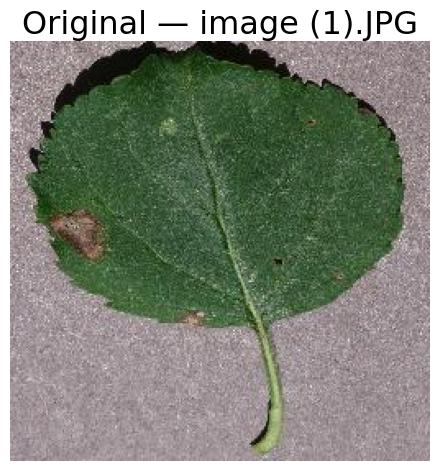

In [15]:
if IMAGE_PATH is None:
    print("Skipping: set IMAGE_PATH to a valid image path (and ensure the model is loaded above).")
    img_rgb = None
else:
    img_bgr = cv2.imread(str(IMAGE_PATH))
    if img_bgr is None:
        print(f"Could not load image: {IMAGE_PATH}")
        img_rgb = None
    else:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        print(f"Loaded: {IMAGE_PATH}")
        print(f"Shape: {img_rgb.shape}")
        plt.figure(figsize=(6, 5))
        plt.imshow(img_rgb)
        plt.title(f"Original — {IMAGE_PATH.name}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

---

## 4. Augmentations

Visualization of the **augmentation pipeline** used at training to balance classes: rotation, blur, contrast, scaling, illumination, perspective. The loaded image plus augmented variants are displayed in a grid. Optional (requires albumentations).

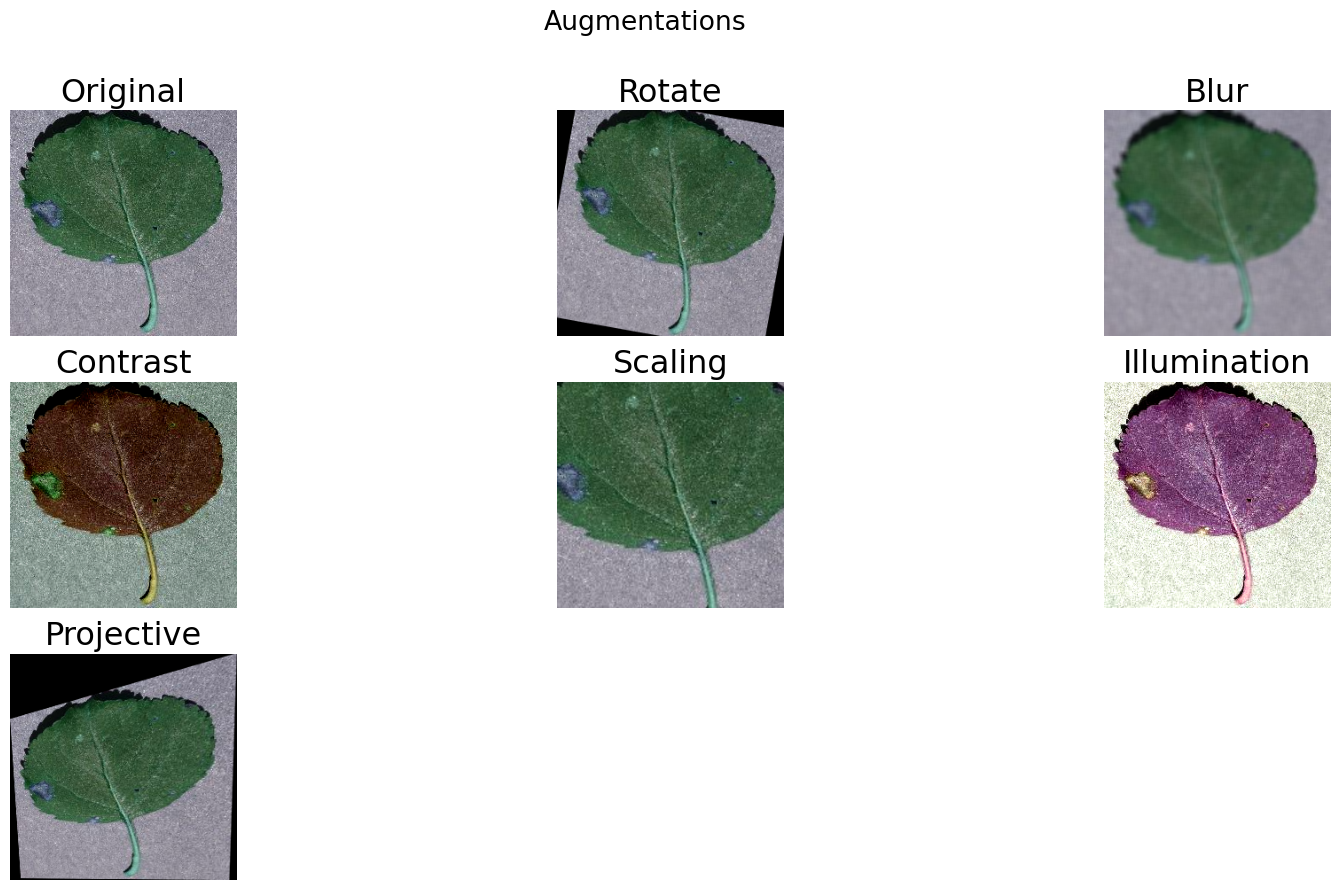

In [16]:
try:
    from leaffliction.augmentations import AugmentationEngine
    from leaffliction.plotting import Plotter
    AUGMENTATION_AVAILABLE = True
except ModuleNotFoundError as e:
    AUGMENTATION_AVAILABLE = False
    print(f"Augmentation demo skipped (missing dependency: {e}). Load an image in section 3 and run sections 5–7 for prediction.")

if AUGMENTATION_AVAILABLE and img_rgb is not None:
    engine = AugmentationEngine()
    results = engine.apply_all_script(img_rgb)
    grid = Plotter()
    grid.plot_grid("Augmentations", results, original=img_rgb)
elif img_rgb is None:
    print("Skipping: load an image in section 3 first.")

---

## 5. Preprocess & transforms

The model expects **4 channels** produced by the **TransformationEngine** (same configuration as in training):

- **Hue** — hue channel for color information related to disease
- **Masked** — leaf mask (background removed) to keep only the useful area
- **AnalyzeImage** — analysis view (plantcv)
- **PseudoLandmarks** — pseudo-landmarks type representation

Each transform produces a channel; they are stacked into a tensor `(1, 4, H, W)`. The image is first resized to the model size (e.g. 224×224). Without plantcv/rembg, grayscale placeholders are displayed with the same names.

Input tensor shape: torch.Size([4, 224, 224])
Transforms: ['Hue', 'Masked', 'AnalyzeImage', 'PseudoLandmarks']


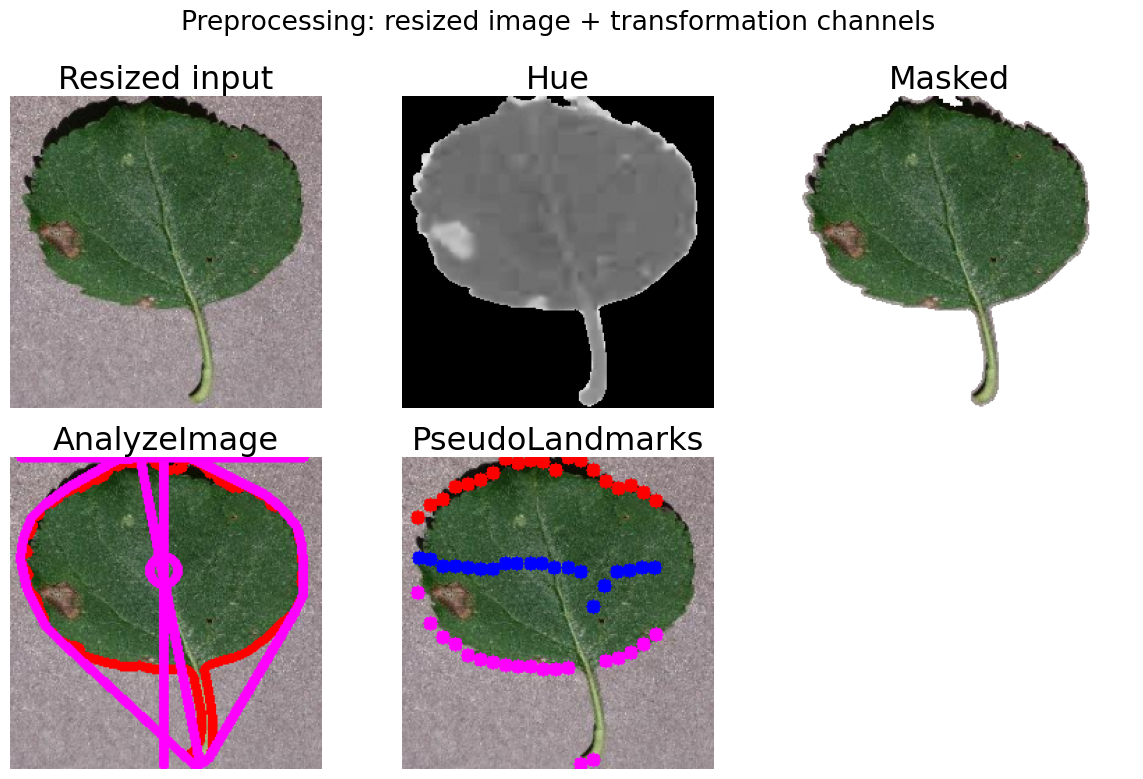

In [17]:
if loader is None or img_rgb is None:
    print("Skipping: load model and image first.")
    tensor = None
    transformed_imgs = None
else:
    img_size = loader.cfg.img_size
    img_resized = cv2.resize(img_rgb, img_size)
    if TRANSFORMATION_ENGINE_AVAILABLE:
        transformation_engine = TransformationEngine.trainning(verbose=False)
        tensor = transformation_engine.apply_all_as_tensor(img_resized)
        transformed_imgs = transformation_engine.apply_all(img_resized)
    else:
        tensor = simple_preprocess_4ch(img_resized, img_size)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
        # Same channel names as in model training (Hue, Masked, AnalyzeImage, PseudoLandmarks); grayscale as placeholder
        transformed_imgs = {
            "Hue": gray,
            "Masked": gray,
            "AnalyzeImage": gray,
            "PseudoLandmarks": gray,
        }
        print("Using simplified preprocessing (grayscale placeholder for all 4 channels; install plantcv/rembg for full transforms).")

    print(f"Input tensor shape: {tensor.shape}")
    print(f"Transforms: {list(transformed_imgs.keys())}")

    # Visualise original + transformed channels
    n = 1 + len(transformed_imgs)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axes = axes.flatten() if n > 1 else [axes]
    axes[0].imshow(img_resized)
    axes[0].set_title("Resized input")
    axes[0].axis("off")
    for i, (name, arr) in enumerate(transformed_imgs.items(), start=1):
        ax = axes[i] if i < len(axes) else None
        if ax is not None:
            if arr.ndim == 3:
                ax.imshow(arr)
            else:
                ax.imshow(arr, cmap="gray")
            ax.set_title(name)
            ax.axis("off")
    for j in range(len(transformed_imgs) + 1, len(axes)):
        axes[j].axis("off")
    plt.suptitle("Preprocessing: resized image + transformation channels")
    plt.tight_layout()
    plt.show()

---

## 6. Predict

The preprocessed tensor (4 channels) is passed to the model. The CNN returns **logits**; we apply **softmax** to get probabilities per class and **argmax** for the predicted class. Same logic as the CLI `predict.py` and `InferenceManager.predict`.

In [18]:
if loader is None or tensor is None:
    print("Skipping: load model and run preprocessing first.")
    predicted_label = None
    probs = None
else:
    pred_id, probs = loader.predict(tensor)
    predicted_label = loader.labels.decode(pred_id)
    print(f"Predicted class: {predicted_label}")
    print(f"Confidence: {probs.get(predicted_label, 0):.2%}")

Predicted class: Apple_Black_rot
Confidence: 100.00%


---

## 7. Interpret

Display of **top-k** classes by probability (same as the `--top-k` CLI option). Allows to see the model's confidence and the most plausible classes. A global evaluation (accuracy on a directory) is done in section 9.

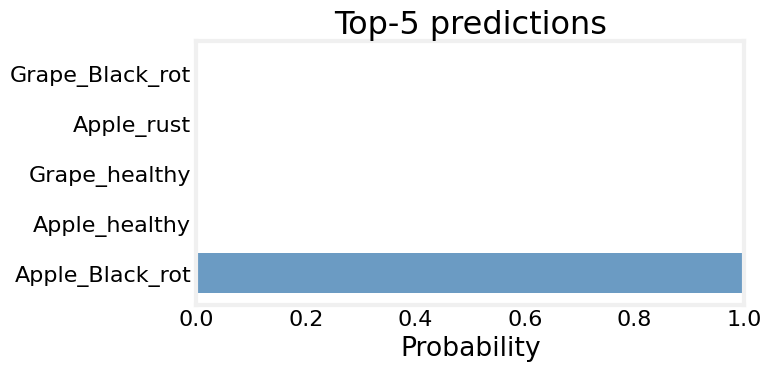

Top-k probabilities:
  1. Apple_Black_rot: 100.00%
  2. Apple_healthy: 0.00%
  3. Grape_healthy: 0.00%
  4. Apple_rust: 0.00%
  5. Grape_Black_rot: 0.00%


In [19]:
TOP_K = 5

if probs is None:
    print("No predictions to show.")
else:
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:TOP_K]
    labels_top = [x[0] for x in sorted_probs]
    values_top = [x[1] for x in sorted_probs]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(range(len(labels_top)), values_top, color="steelblue", alpha=0.8)
    ax.set_yticks(range(len(labels_top)))
    ax.set_yticklabels(labels_top)
    ax.set_xlabel("Probability")
    ax.set_title(f"Top-{TOP_K} predictions")
    ax.set_xlim(0, 1)
    plt.tight_layout()
    plt.show()

    print("Top-k probabilities:")
    for i, (label, p) in enumerate(sorted_probs, 1):
        print(f"  {i}. {label}: {p:.2%}")

---

## 8. Appendix — Technical context

### Recognized classes (8)

Apple_Black_rot, Apple_healthy, Apple_rust, Apple_scab, Grape_Black_rot, Grape_Esca, Grape_healthy, Grape_spot.

### Input and preprocessing

- **Input:** RGB image (JPG, PNG, etc., via OpenCV).
- **Pipeline:** resizing to model size (ex. 224×224), then the 4 transforms (Hue, Masked, AnalyzeImage, PseudoLandmarks) to obtain a 4-channel tensor, values in [0, 1].

### Model architecture

**ConvolutionalNeuralNetwork** (`leaffliction/model.py`): 4 Conv2d → ReLU → MaxPool2d blocks (32 → 64 → 128 → 256 channels), Global Average Pooling, then classifier Linear(256→128) → ReLU → Dropout(0.5) → Linear(128→8). Output: logits; softmax gives probabilities per class.

### Project metrics

- **Training:** train/validation accuracy and loss per epoch in `train_pipeline.py`; constraint: validation ≥ 90% and at least 100 validation examples (ModelChecker).
- **Directory evaluation:** `predict.py --dir-path` infers the true class from the subdirectory name and reports accuracy.

---

## 9. Directory evaluation (test set)

Model evaluation on **an entire directory** of labeled images (e.g. `test_images/20/` (16 images) or `test_images/100/` (160 images)). The command below compares, for each image, the **predicted class** to the **true class** (deduced from subdirectory name) and displays a summary.

**Command (to run from repository root):**

```bash
python predict.py --dir-path ./test_images/20 --model-path ./worked/model --verbose
```

**Reading the summary:**

- **Total images** — Number of processed images.
- **Correct** — Number of correct predictions.
- **Accuracy** — Correct/Total (e.g. 152/160 → 95%).
- **True label distribution** — Actual class distribution in the directory (e.g. 20 images per class).
- **Predicted label distribution** — Distribution of predictions by class. Deviations from the true distribution indicate model confusions (e.g. one class over-predicted, another under-predicted).

In [20]:
# Install dependencies required by predict.py (plantcv, rembg). Skip if already present (e.g. local env).
try:
    import plantcv
    import rembg
except ModuleNotFoundError:
    !pip install -q plantcv rembg onnxruntime

# Run directory evaluation via CLI (full preprocessing pipeline → correct accuracy)
!python predict.py --dir-path ./test_images/20 --model-path ./worked/model --verbose

[INFO] ============================================================
[INFO] LEAFFLICTION - PyTorch Prediction
[INFO] ============================================================
[INFO]    Model: None
[INFO]    Dir path: test_images/20
[INFO] ============================================================
[INFO]
[INFO] Loading model loader from directory...
/home/dagudelo/Projects/Leaffliction/leaffliction/model.py:341: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they